# Guide RNA assignment

Assigning relevant guides to each cell is essential for quality control in perturbation assays, ensuring that the observed cellular responses are accurately linked to the intended genetic modifications. 
This step is critical for validating the experimental design and interpreting results reliably, thereby maintaining the integrity and reproducibility of the research.
Here, we demonstrate how to visualize guide RNAs in a perturbation assay and how to assign relevant guides to each cell.

## Setup

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pertpy as pt
import scanpy as sc
import scipy
import seaborn as sns

# Simulated Data

In [2]:
import jax.numpy as jnp
from anndata import AnnData
from jax import random


def generate_toy_data(n_guides=3, n_cells_per_group=50):
    dats = []
    for i in range(n_guides):
        # Simulate positive and negative population for each guide
        key = random.PRNGKey(i)
        key1, key2 = random.split(key)

        # Negative first
        poisson_data = random.poisson(key1, lam=0.1, shape=n_cells_per_group * i).astype(jnp.float32)

        # Positive
        gaussian_data = random.normal(key2, shape=n_cells_per_group) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)

        # Negative second
        poisson_data_ = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * (n_guides - i - 1))).astype(
            jnp.float32
        )

        # The count vector for one guide is the concatenation of the negative and positive populations
        guide_data = jnp.hstack([poisson_data, gaussian_data, poisson_data_])
        dats.append(guide_data)
    guide_counts = np.array(jnp.vstack(dats)).T

    # Combine Poisson and Gaussian data into one dataset
    adata = AnnData(
        guide_counts,
        obs=pd.DataFrame(index=[f"cell{i + 1}" for i in range(guide_counts.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i + 1}" for i in range(guide_counts.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide" + str(i + 1) for i in range(n_guides) for _ in range(n_cells_per_group)]
    return adata

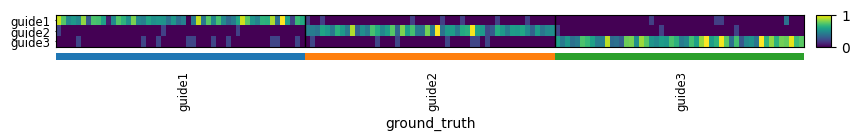

In [3]:
adata = generate_toy_data(n_guides=3, n_cells_per_group=50)
sc.pl.heatmap(
    adata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=adata.var_names, swap_axes=True
)

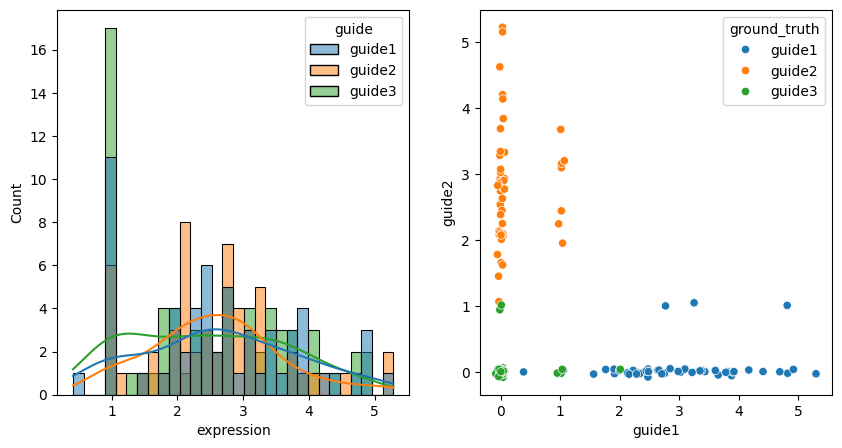

In [ ]:
df = adata.to_df().stack().reset_index().rename(columns={"level_0": "cell", "level_1": "guide", 0: "expression"})

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df = df[df.expression > 0]
sns.histplot(df, x="expression", hue="guide", bins=30, kde=True, ax=axs[0])
df = adata.to_df()
df = np.random.default_rng().normal(0, 0.03, df.shape) + df
sns.scatterplot(data=df, x="guide1", y="guide2", hue=adata.obs["ground_truth"], ax=axs[1])
plt.show()

In [8]:
adata

AnnData object with n_obs × n_vars = 150 × 3
    obs: 'ground_truth', 'assigned_guide'
    var: 'gaussian_mean', 'gaussian_std', 'mix_probs', 'poisson_rate'
    uns: 'ground_truth_colors'

In [5]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(adata)

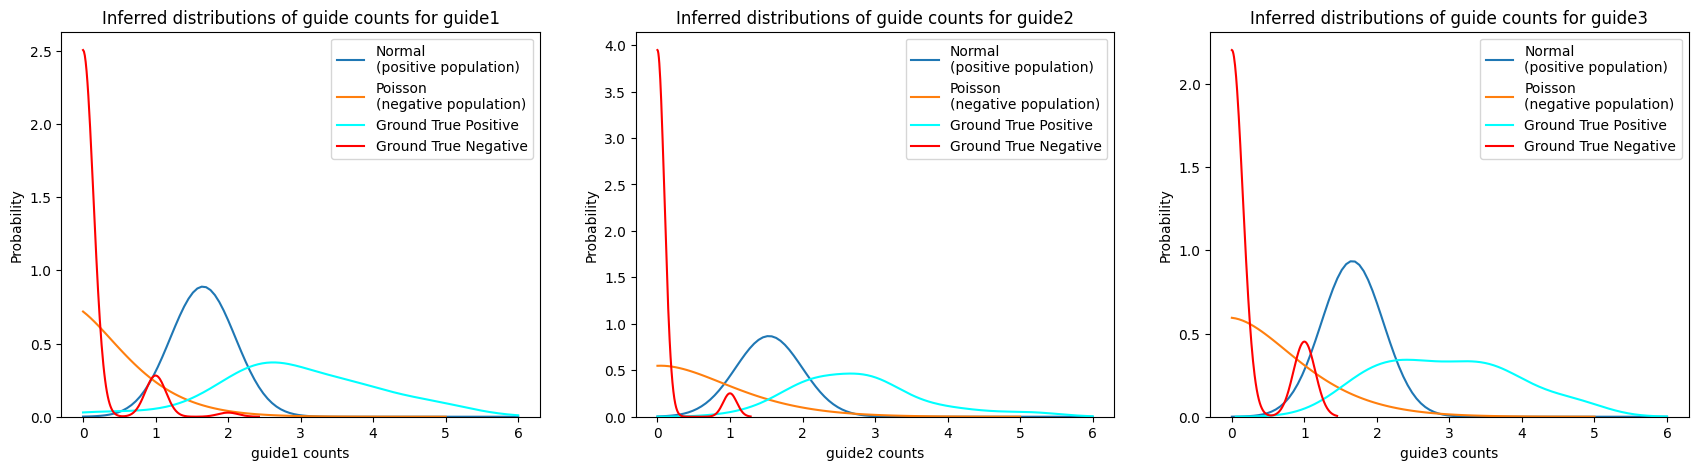

In [9]:
import numpyro.distributions as dist

# plot probability distributions of model
n_guides = len(adata.var_names)
guides = adata.var_names
fig, axs = plt.subplots(1, n_guides, figsize=(7 * n_guides, 5))
for ax, guide in zip(axs, guides, strict=False):
    # plot gaussian distribution
    x = np.linspace(0, 6, 100)
    y = dist.Normal(
        adata.var.loc[guide, "gaussian_mean"],
        adata.var.loc[guide, "gaussian_std"],
    ).log_prob(x)
    ax.plot(x, np.exp(y), label="Normal\n(positive population)")
    # plot poisson distribution
    x = np.linspace(0, 5, 100)
    y = dist.Poisson(adata.var.loc[guide, "poisson_rate"]).log_prob(x)
    ax.plot(x, np.exp(y), label="Poisson\n(negative population)")
    # Plot ground truth empirical distribution
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth == guide, guide].X),
        color="cyan",
        label="Ground True Positive",
        ax=ax,
        clip=(0, 6),
    )
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth != guide, guide].X),
        color="red",
        label="Ground True Negative",
        ax=ax,
        clip=(0, 6),
    )

    ax.set_xlabel(f"{guide} counts")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_title(f"Inferred distributions of guide counts for {guide}")

plt.show()

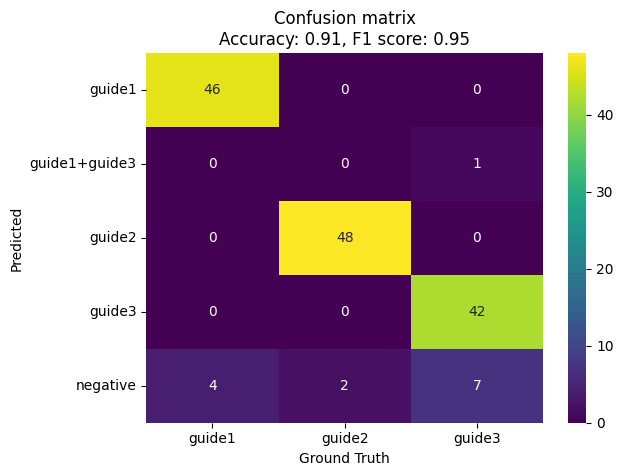

In [10]:
# evaluate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(adata.obs["ground_truth"], adata.obs["assigned_guide"])
f1 = f1_score(adata.obs["ground_truth"], adata.obs["assigned_guide"], average="weighted")

labels = np.unique(adata.obs["assigned_guide"])
cm = confusion_matrix(adata.obs["ground_truth"], adata.obs["assigned_guide"], labels=labels)
cm = pd.DataFrame(cm, index=labels, columns=labels).loc[adata.obs["ground_truth"].unique()]
ax = sns.heatmap(cm.T, annot=True, fmt="d", cmap="viridis")
ax.set_ylabel("Predicted")
ax.set_xlabel("Ground Truth")
plt.title(f"Confusion matrix\nAccuracy: {np.round(accuracy, 2)}, F1 score: {np.round(f1, 2)}")
plt.show()

In [11]:
adata.obs["assigned_guide"].value_counts()

assigned_guide
guide2           48
guide1           46
guide3           42
negative         13
guide1+guide3     1
Name: count, dtype: int64

In [62]:
5 // 2

2

In [18]:
adata.var.gaussian_mean = adata.var.gaussian_mean.astype(float)
adata.var.gaussian_std = adata.var.gaussian_std.astype(float)
adata.var.poisson_rate = adata.var.poisson_rate.astype(float)
if "mix_probs" in adata.var.columns:
    adata.var.drop(columns="mix_probs", inplace=True)
adata.write_h5ad("/scratch/peidli/pertpy_benchmark/sim_dat.h5ad")

# Compare

In [12]:
import crispat

In [61]:
# Not working
crispat.ga_poisson_gauss(
    "/scratch/peidli/pertpy_benchmark/sim_dat.h5ad",
    "/scratch/peidli/pertpy_benchmark/sim_dat_crispat_ga_umi",
    start_gRNA=1,
)

Guide assignment with Poisson-Gaussian mixture model as in Replogle et al.
Load gRNA counts
Fit Poisson-Gaussian Mixture Model for each gRNA: 


  0%|          | 0/3 [00:00<?, ?it/s]

/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  warn_if_nan(
/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/infer/traceenum_elbo.py:412: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  warn_if_nan(
/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/infer/traceenum_elbo.py:412: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  warn_if_nan(
/home/peidli/miniconda3/envs/crispat_compare/lib/python3.10/site-packages/pyro/infer/traceenum_elbo.py:412: UserWarnin

ValueError: Expected parameter probs (Tensor of shape (2,)) of distribution Categorical(probs: torch.Size([2])) to satisfy the constraint Simplex(), but found invalid values:
tensor([nan, nan], grad_fn=<DivBackward0>)
Trace Shapes:       
 Param Sites:       
Sample Sites:       
 weights dist    | 2
        value    | 2
      mu dist    |  
        value    |  
   scale dist    |  
        value    |  
     lam dist    |  
        value    |  
    data dist    |  
        value 60 |  

In [51]:
crispat_df = pd.read_csv("/scratch/peidli/pertpy_benchmark/sim_dat_crispat_ga_umiassignments_t1.csv")
crispat_df = crispat_df.groupby("cell", as_index=False).agg(
    {
        "gRNA": lambda x: "+".join(x),
        "UMI_counts": "sum",  # You can change the aggregation for UMI_counts as needed
    }
)
crispat_df.set_index("cell", inplace=True)
crispat_df.rename(columns={"gRNA": "assigned_guide_crispat"}, inplace=True)

In [52]:
crispat_df

,assigned_guide_crispat,UMI_counts
cell,,
cell1,guide1+guide2,5.854674
cell10,guide1,3.017952
cell100,guide2,2.580228
cell101,guide2+guide3,3.721479
cell102,guide3,1.986992
...,...,...
cell95,guide1+guide2,3.478331
cell96,guide2,1.637510
cell97,guide2,2.822208
